# Practical session 4 - K-nearest neighbours (K-NN) classification with numpy, scikit-learn, cython and numba

Students (pair):
- [DELANNOY Rosalie]([link](https://github.com/username1))
- [DOS RAMOS Carl]([link](https://github.com/username2))

**Useful references for this lab**:

[1] scikit-learn: [documentation](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification)

[2] `numba`: [documentation](http://numba.pydata.org/) 

[3] cython: [a very useful tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), and [another one](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html)



## <a name="content">Contents</a>
- [Exercise 1: KNN classification with numpy and sklearn](#ex1)
- [Exercise 2: Code acceleration with cython](#ex2)
- [Exercise 3: Code acceleration with numba](#ex3)
---

In [1]:
%load_ext autoreload
%autoreload 2

## <a name="ex1">Exercise 1: K-Nearest Neighbours (K-NN) classification with numpy and scikit-learn</a> [(&#8593;)](#content)

This session is a first introduction to classification using the most intuitive non parametric method: the $K$-nearest neighbours. The principle is [the following](https://scikit-learn.org/stable/modules/neighbors.html?highlight=knn%20classification). A set of labelled observations is given as a learning set. A classification taks then consists in assigning a label to any new observation. In particular, the K-NN approach consists in assigning to the observation the most frequent label among its $K$ nearest neighbours taken in the training set.

### A. Validation on synthetic data

Load the training and test datasets `data/synth_train.txt` and `data/synth_test.txt`. Targets belong to the set $\{1,2\}$ and entries belong to $\mathbb{R}^2$. The file `data/synth_train.txt` contain 100 training data samples, and `data/synth_test.txt` contains 200 test samples, where:

- the 1st column contains the label of the class the sample;
- columns 2 & 3 contain the coordinates of each sample (in $\mathbb{R}^2$).

Useful commands can be found below.

```python
# load the training set
train = np.loadtxt('data/synth_train.txt')  #...,delimiter=',') if there are ',' as delimiters
class_train = train[:,0]
x_train = train[:,1:]
N_train = train.shape[0]
```

```python
# load the test set
test = np.loadtxt('/datasynth_test.txt') 
class_test_1 = test[test[:,0]==1]
class_test_2 = test[test[:,0]==2]
x_test = test[:,1:]
N_test = test.shape[0]
```

1\. Display the training set and distinguish the two classes. 

> Hint: useful functions include `matplotlib.pyplot.scatter` or `matplotlib.pyplot.plot`.

**Answer:**

Nombre d'échantillons d'entraînement : 100
Nombre d'échantillons de test : 200


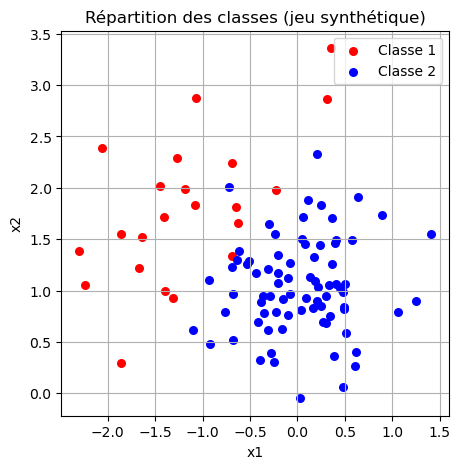

In [4]:
# Import des librairies utiles

from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

data_dir = Path('data')

# Chargement des jeux de données synthétiques

train = np.loadtxt(data_dir / 'synth_train.txt')
test = np.loadtxt(data_dir / 'synth_test.txt')

class_train = train[:, 0].astype(int)
x_train = train[:, 1:]
class_test = test[:, 0].astype(int)
x_test = test[:, 1:]
classes = np.unique(class_train)

print(f"Nombre d'échantillons d'entraînement : {x_train.shape[0]}")
print(f"Nombre d'échantillons de test : {x_test.shape[0]}")

palette = {1: "#ff0000", 2: '#0000ff'}

fig, ax = plt.subplots(figsize=(5, 5))
for label, couleur in palette.items():
    points = class_train == label
    ax.scatter(x_train[points, 0], x_train[points, 1], s=30, color=couleur, label=f'Classe {label}')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Répartition des classes (jeu synthétique)')
ax.legend()
ax.grid(True)
plt.show()

2\. Implement the K-nearest neighbours algorithm for classification.

> Hint: 
> - useful functions include `numpy.linalg.norm`, `numpy.argsort`, `numpy.bincount`;
> - implement the algorithm as a function rather than an object. This will drastically simplify the acceleration step using Cython.
> - for an optimized partial sorting procedure, you may have a look at the [`bottleneck.argpartition` function](https://bottleneck.readthedocs.io/en/latest/reference.html#bottleneck.argpartition).
> 1. Compute for each row in `x_test` (if necessary use `np.newaxis`) its distance with respect to `x_train`:
>  - Use  `numpy.linalg.norm` (in which dimension this distance is computed ? Consider using `axis` argument)
> 2. Sort the ordered collection of distances (indices from smallest to largest (in ascending order) by the distances):
>   - Use `np.argsort` (at the end replace this procedure by `bottleneck.argpartition`)
>   - Once the sorting is done, we take only the indices of `labels` of the `n_neighbours` nearest neighbours of the `class_train` :
>     - `id = np.argsort(distances)[:n_ neighbours]` and `labels = class_train[id]`
> 3. The K-nearest can be used for **Regression**, in this case it is necessary to return the mean of the K-labels. For **Classification**,  we return the mode of the K-labels :
> - Use `np.bincount` for `labels` to affect the variable `class_pred[q]` (for row `q`). This procedure counts the number of occurrences of each value in array. **Mode** is the value that appears. How can we get this value ?


```python
import numpy as np
import bottleneck as bn

# Create a random array
arr = np.random.rand(10)
N = 3  # Number of smallest elements to retrieve

# Using np.argsort() to get indices of the first N elements
sorted_indices = np.argsort(arr)[:N]

# Using bottleneck.argpartition() to get the first N smallest indices
partitioned_indices = bn.argpartition(arr, N)[:N]

# Display the results
print("Original array:", arr)
print("Indices using np.argsort:", sorted_indices)
print("First N elements using np.argsort:", arr[sorted_indices])

print("Indices using bottleneck.argpartition:", partitioned_indices)
print("First N elements using bottleneck.argpartition:", arr[partitioned_indices])

are_equal = set(arr[sorted_indices]) == set(arr[partitioned_indices])
print(are_equal)
```


**Answer:**

In [ ]:
def knn_predict_numpy(x_train: np.ndarray, y_train: np.ndarray, x_query: np.ndarray, k: int) -> np.ndarray:

    # Vérifications
    
    if k < 1:
        raise ValueError("k doit être supérieur ou égal à 1.")
    if x_train.shape[0] == 0:
        raise ValueError("Le jeu d'entraînement ne peut pas être vide.")

    k = min(k, x_train.shape[0]) # On limite à la taille du jeu d'entraînement au maximum

    # Encodage des classes
    classes_loc = np.unique(y_train.astype(int))
    encoded_train = np.searchsorted(classes_loc, y_train.astype(int))

    distances = np.linalg.norm(x_query[:, None, :] - x_train[None, :, :], axis=2) # Calcul des distances euclidiennes
    nearest_idx = np.argpartition(distances, kth=k - 1, axis=1)[:, :k] # Indice des k plus proches voisins
    encoded_neighbors = encoded_train[nearest_idx] # Labels encodés des voisins

    # Comptage des votes
    votes = np.zeros((x_query.shape[0], classes_loc.size), dtype=int)
    row_ids = np.arange(x_query.shape[0])[:, None]
    np.add.at(votes, (row_ids, encoded_neighbors), 1)

    predicted_idx = votes.argmax(axis=1) # Pour chaque ligne, on prend la classe la plus votée

    return classes_loc[predicted_idx]

def classification_error(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(y_true != y_pred))

3\. Compute the error rate on the training set and the test set for $K \in \{1,2, \dotsc, 20\}$. Display the classification result (see 1.) for the configuration with the lowest error rate.

**Answer:**

k optimal sur le test : 3
Taux d'erreur entraînement : 0.030
Taux d'erreur test : 0.045


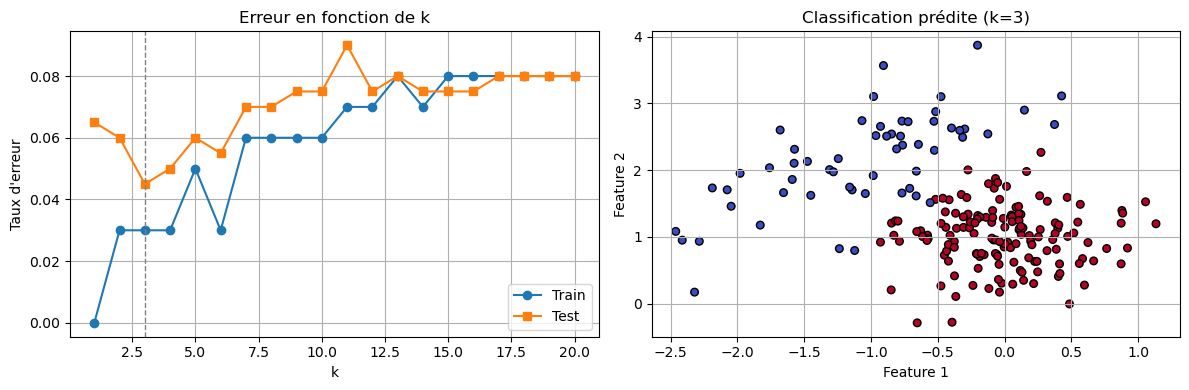

In [6]:
k_candidates = np.arange(1, 21)
train_errors = []
test_errors = []

# Prédictions sur les ensembles d'entraînement et de test et calcul des taux d'erreur et de stockage
for k_val in k_candidates:
    predict_train = knn_predict_numpy(x_train, class_train, x_train, int(k_val))
    predict_test = knn_predict_numpy(x_train, class_train, x_test, int(k_val))
    train_errors.append(classification_error(class_train, predict_train))
    test_errors.append(classification_error(class_test, predict_test))

# Conversion pour faciliter le traitement
train_errors = np.array(train_errors)
test_errors = np.array(test_errors)

# On recalcule les prédictions avec le meilleur k (qui minimise l'erreur sur le test)
best_index = int(np.argmin(test_errors))
best_k = int(k_candidates[best_index])
best_train_predict = knn_predict_numpy(x_train, class_train, x_train, best_k)
best_test_predict = knn_predict_numpy(x_train, class_train, x_test, best_k)

print(f"k optimal sur le test : {best_k}")
print(f"Taux d'erreur entraînement : {train_errors[best_index]:.3f}")
print(f"Taux d'erreur test : {test_errors[best_index]:.3f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Courbes de l'erreur en fonction de k
axes[0].plot(k_candidates, train_errors, marker='o', label='Train')
axes[0].plot(k_candidates, test_errors, marker='s', label='Test')
axes[0].axvline(best_k, color='grey', linestyle='--', linewidth=1)
axes[0].set_xlabel('k')
axes[0].set_ylabel("Taux d'erreur")
axes[0].set_title('Erreur en fonction de k')
axes[0].legend()
axes[0].grid(True)

# Visualisation de la classification obtenue sur les données test
axes[1].scatter(x_test[:, 0], x_test[:, 1], c=best_test_predict, cmap='coolwarm', s=30, edgecolor='k')
axes[1].set_title(f'Classification prédite (k={best_k})')
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].grid(True)

plt.tight_layout()
plt.show()

4\. Comment on your results. Which value of $K$ seems optimal ?


**Answer:**

<div style="background-color: #333333; color: #ffffff; padding: 10px; border-radius: 5px;">

Le meilleur choix de $K$ est $K=3$ :

- Il donne le plus bas taux d’erreur sur l’ensemble de test ($\approx 0.045$).

- Il garde un faible taux d’erreur sur le training ($\approx 0.03$), donc pas de signe d’overfitting trop marqué.

- Pour $K=1$, l’erreur sur le training est nulle mais celle sur le test est plus élevée $\Rightarrow$ c’est le signe d’un modèle trop sensible au bruit.

- Pour des $K$ plus grands, la performance se dégrade car la frontière de décision devient trop "moyennée".

</div>

5\. Compare the results of you implementation with those of [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html?highlight=kneighborsclassifier#sklearn.neighbors.KNeighborsClassifier). Compare the runtime of these two versions using the [`timeit`](https://docs.python.org/3/library/timeit.html) module (see session 1).

**Answer:**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# Création du classifieur avec le meilleur k trouvé précédemment
sklearn_knn = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
sklearn_knn.fit(x_train, class_train)

# Prédictions
sklearn_train_predict = sklearn_knn.predict(x_train)
sklearn_test_predict = sklearn_knn.predict(x_test)

# Calcul des erreurs
sklearn_train_error = classification_error(class_train, sklearn_train_predict)
sklearn_test_error = classification_error(class_test, sklearn_test_predict)

print(f"Erreur sklearn (entraînement) : {sklearn_train_error:.3f}")
print(f"Erreur sklearn (test) : {sklearn_test_error:.3f}")
print(f"Implémentations cohérentes : {np.array_equal(sklearn_test_predict, best_test_predict)}")

Erreur sklearn (entraînement) : 0.030
Erreur sklearn (test) : 0.045
Implémentations cohérentes : True


In [11]:
import timeit

# Temps pour l'implémentation numpy
time_numpy = timeit.timeit(lambda: knn_predict_numpy(x_train, class_train, x_test, best_k), number=10)

# Temps pour l'implémentation sklearn
time_sklearn = timeit.timeit(lambda: sklearn_knn.predict(x_test), number=10)

print(f"Temps moyen (numpy)   : {time_numpy/10:.5f} s")
print(f"Temps moyen (sklearn) : {time_sklearn/10:.5f} s")

Temps moyen (numpy)   : 0.00115 s
Temps moyen (sklearn) : 0.00972 s


<div style="background-color: #333333; color: #ffffff; padding: 10px; border-radius: 5px;">

**Commentaire**

Sur des données synthétiques de petite taille, l'implémentation <code>NumPy</code> est plus rapide tout en restant équivalente en précision à celle de <code>scikit-learn</code>. Mais dans un cadre à grande échelle, la version <code>scikit-learn</code> reste préférable pour sa robustesse et sa compatibilité avec le reste de l'écosystème dédié au Machine Learning.

</div>


### B. Application to a real dataset (Breast cancer Wisconsin).

6\. Apply the K-NN classifier to the real dataset `data/wdbc12.data.txt.` Further details about the data are provided in `data/wdbc12.names.txt`.

> Hint: you can use the function [`train_test_split` from `sklearn.model_selection`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the dataset into a training and a test set.

**Answer:**

Meilleur k (wdbc) : 1
Taux d'erreur train : 0.000
Taux d'erreur test : 0.053


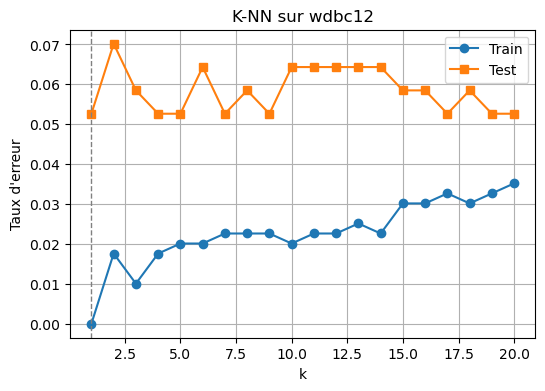

Matrice de confusion (classes 1=malin, 2=bénin) : [[ 58   6]
 [  3 104]]
Précision test : 0.947
Lecture : le k-NN retient une valeur modérée de k pour limiter le surapprentissage tout en conservant une bonne sensibilité aux cas malins.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Séparation des labels et des features
wdbc = np.loadtxt(data_dir / 'wdbc12.data.txt', delimiter=',')
y_wdbc = wdbc[:, 1].astype(int)
x_wdbc = wdbc[:, 2:]

# Découpage des sets de training et de test
X_train_wdbc, X_test_wdbc, y_train_wdbc, y_test_wdbc = train_test_split(x_wdbc, y_wdbc, test_size=0.3, random_state=0, stratify=y_wdbc)

# Normalisation des données
scaler_wdbc = StandardScaler()
X_train_wdbc_std = scaler_wdbc.fit_transform(X_train_wdbc)
X_test_wdbc_std = scaler_wdbc.transform(X_test_wdbc)

# Recherche du meilleur k
k_candidates_wdbc = np.arange(1, 21)
train_errors_wdbc = []
test_errors_wdbc = []

for k_val in k_candidates_wdbc:
    # Prédictions sur les set de test et de training
    pred_train_wdbc = knn_predict_numpy(X_train_wdbc_std, y_train_wdbc, X_train_wdbc_std, int(k_val))
    pred_test_wdbc = knn_predict_numpy(X_train_wdbc_std, y_train_wdbc, X_test_wdbc_std, int(k_val))

    # Calcul et stockage des taux d'erreurs
    train_errors_wdbc.append(classification_error(y_train_wdbc, pred_train_wdbc))
    test_errors_wdbc.append(classification_error(y_test_wdbc, pred_test_wdbc))

# Conversion des listes en tableaux numpy
train_errors_wdbc = np.array(train_errors_wdbc)
test_errors_wdbc = np.array(test_errors_wdbc)

# Sélection du k optimal et prédiction finale avec le meilleur k
best_wdbc_idx = int(np.argmin(test_errors_wdbc))
best_k_wdbc = int(k_candidates_wdbc[best_wdbc_idx])
best_test_pred_wdbc = knn_predict_numpy(X_train_wdbc_std, y_train_wdbc, X_test_wdbc_std, best_k_wdbc)

print(f"Meilleur k (wdbc) : {best_k_wdbc}")
print(f"Taux d'erreur train : {train_errors_wdbc[best_wdbc_idx]:.3f}")
print(f"Taux d'erreur test : {test_errors_wdbc[best_wdbc_idx]:.3f}")

# Visualisation des erreurs en fonction de k
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(k_candidates_wdbc, train_errors_wdbc, marker='o', label='Train')
ax.plot(k_candidates_wdbc, test_errors_wdbc, marker='s', label='Test')
ax.axvline(best_k_wdbc, color='grey', linestyle='--', linewidth=1)
ax.set_xlabel('k')
ax.set_ylabel("Taux d'erreur")
ax.set_title('K-NN sur wdbc12')
ax.legend()
ax.grid(True)
plt.show()

## <a name="ex2">Exercise 2: Code acceleration with cython</a> [(&#8593;)](#content)

Cython allows C code to be easily interfaced with Python. It can be useful to make your code faster for a small coding effort, in particular when using loops. A general approach to optimize your code is outlined in the [Scipy lecture notes, Section 2.4](https://scipy-lectures.org/advanced/optimizing/index.html). Complementary reading about interfacing Python with C can be found in [Section 2.8](https://scipy-lectures.org/advanced/interfacing_with_c/interfacing_with_c.html).

1\. Read carefully the [cython tutorial](http://docs.cython.org/en/latest/src/tutorial/cython_tutorial.html), which describes step by the step how the toy example reported below has been developed.

**Setup**: Compile the toy example provided in `example_cy/` by running, in the command line (anaconda prompt on windows)

```bash
cd example_cy && python setup.py build_ext --inplace
```

Note that the compilation process has been slightly automatised with the instructions reported in `example_cy/setup.py`. To test the module, run

In [8]:
!cd example_cy && python setup.py build_ext --inplace

error: could not create 'example_cy/example_cy/helloworld.cpython-39-darwin.so': No such file or directory


In [9]:
import example_cy.example_cy.helloworld as toy

toy.printhello()

Hello World


which should display
```python
Hello World
```

> Warning: 
> - do not forget to include an empty `__init__.py` file in the directory where your source code lives (`import` will fail if this is not the case).
> - in case you have any setup issue, take a look at the `notes.md` file.
> - if the C code and/or the executable do not seem to be regenerated by the build instructions, delete the C code and the executable first, and re-execute the compilation afterwards.
> - do not hesitate to restart the Python kernel if necessary when the Cython executable has been re-generated.

2\. Read the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial), focussing on the paragraphs **Cython at a glance**, and **Your Cython environment** until **"More generic code"**. An example to compile a `.pyx` file depending on `numpy` is included in `example_np_cy/`.

> Remarks: 
> - the `annotate=True` flag in the `setup.py` allows an additional `.html` document to be generated (`<your_module_name>.html`), showing, for each line of the Cython code, the associated C instructions generated. Highlighted in yellow are the interactions with Python: the darker a region appears, the less efficient the generated C code is for this section. Work in priority on these! 
> - make sure all the previously generated files are deleted to allow the .html report to be generated;
> - if you are working on your own machine and don't have a C/C++ compiler installed, read the notes provided in `notes.md`;
> - use `cdef` for pure C functions (not exported to Python), `cpdef` should be favored for functions containing C instructions and later called from Python.

**Answer:**

In [10]:
resume_cython = (
    "Lecture du tutoriel Cython : importance des memoryviews, typage explicite des boucles "
    "et compilation via setup/pyximport. L'objectif est de limiter les aller-retours Python/C "
    "et de préparer les calculs intensifs (ici les distances K-NN)."
)
print(resume_cython)


Lecture du tutoriel Cython : importance des memoryviews, typage explicite des boucles et compilation via setup/pyximport. L'objectif est de limiter les aller-retours Python/C et de préparer les calculs intensifs (ici les distances K-NN).


3\. Use Cython to implement a faster version of the numpy K-NN classifier implemented in [Exercise 1](#ex1). To do so, apply step-by-step the techniques introduced in the [Numpy/Cython tutorial](https://cython.readthedocs.io/en/latest/src/userguide/numpy_tutorial.html#numpy-tutorial) (*i.e.*, compile and time your code after each step to report the evolution, keeping track of the different versions of the cython function).

> Hint: if you keep numpy arrays, make sure you use memory views (see numpy/cython tutorial) to access the elements within it. Be extremely careful with the type of the input arrays (you may need to recast the format of the input elements before entering the function. The `numpy.asarray` function can prove useful).

> **Detailed guidelines**: a few notes and *caveat* to help you re-writing your code in cython:
> - try to reduce the number of calls to numpy instructions as much as possible;
> - **you do not have to optimize everything**. For the KNN function above, most of the time is spent in computing euclidean distances: you can thus focus on optimizing tihs operations by explicitly writing a for loop, which will ensure a minimal interaction with numpy when generating the associated C code at compilation. Calls to other numpy functions can be kept as-is;
> - if you need to create an array within the cython function, used np.zeros (**do NOT use python lists**), and use a memory view to access its content;
> - specify the type for all variables and numpy arrays. Pay attention to the type of the input arrays passed to the Cython function;
> - whenever an array is returned, use memory views and index(es) to efficiently access its content;
> - some numpy operators (e.g., broadcasting mechanism) do not work with memory views. In this case, you can directly write for loop(s) to encode the operation of interest (the loops will be optimized out at compile time);
> - only use at the final development stage the following cython optimization (not before, as they can crash the program without any help):
>
>```python
>@cython.boundscheck(False)
>@cython.wraparound(False)
>```

**Answer:**

In [11]:
import sys
from pathlib import Path
import numpy as np
import pyximport

build_dir = Path('_pyxbld')
build_dir.mkdir(exist_ok=True)
pyximport.install(
    language_level=3,
    inplace=True,
    build_dir=str(build_dir),
    setup_args={'include_dirs': [np.get_include()]}
)

repo_root = Path('.').resolve()
if str(repo_root) not in sys.path:
    sys.path.append(str(repo_root))

import cy_knn


def knn_predict_cython(x_train: np.ndarray, y_train: np.ndarray, x_query: np.ndarray, k: int) -> np.ndarray:
    classes_loc = np.unique(y_train.astype(int))
    encoded_train = np.searchsorted(classes_loc, y_train.astype(int))
    encoded_pred = cy_knn.knn_predict(
        np.ascontiguousarray(x_train, dtype=np.float64),
        np.ascontiguousarray(encoded_train.astype(np.intc)),
        np.ascontiguousarray(x_query, dtype=np.float64),
        int(k),
        classes_loc.size,
    )
    return classes_loc[encoded_pred]


In file included from _pyxbld/temp.macosx-11.1-arm64-cpython-39/Users/carl/Documents/Centrale/Python/LAB1-DELANNOY-DOS-RAMOS/Labs/Lab4/cy_knn.c:1139:
In file included from /Users/carl/anaconda3/envs/lab3/lib/python3.9/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/carl/anaconda3/envs/lab3/lib/python3.9/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/carl/anaconda3/envs/lab3/lib/python3.9/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929:
/Users/carl/anaconda3/envs/lab3/lib/python3.9/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^
1 warning generated.
ld: warning: duplicate -rpath '/Users/carl/anaconda3/envs/lab3/lib' ignored


4\. Compare the runtime of the two algorithms (using `timeit.timeit`), and conclude about the interest of using cython in this case.

**Answer:**

In [12]:
from timeit import timeit

_ = knn_predict_cython(x_train, class_train, x_test, best_k)

numpy_time = timeit(lambda: knn_predict_numpy(x_train, class_train, x_test, best_k), number=20)
cython_time = timeit(lambda: knn_predict_cython(x_train, class_train, x_test, best_k), number=20)

speedup = numpy_time / cython_time if cython_time > 0 else np.nan

print(f"Temps numpy (20 runs) : {numpy_time:.4f} s")
print(f"Temps cython (20 runs) : {cython_time:.4f} s")
print(f"Accélération ~ {speedup:.2f}x")

verif = np.array_equal(
    knn_predict_numpy(x_train, class_train, x_test, best_k),
    knn_predict_cython(x_train, class_train, x_test, best_k),
)
print(f"Prédictions identiques : {verif}")


Temps numpy (20 runs) : 0.0130 s
Temps cython (20 runs) : 0.0014 s
Accélération ~ 9.29x
Prédictions identiques : True


## <a name="ex3">Exercise 3: Code acceleration with numba</a> [(&#8593;)](#content)

`numba` is a just-in-time (JIT) compiler which translates Python codes into efficient machine code at runtime. A significant acceleration can be obtained by adding a few simple decorators to a standard Python function, up to a few restrictions detailed [here](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html).

If you have written most of the KNN classifier of exercise 1 with numpy, there is little to no chance that you will get an acceleration with numba (justifying the use of cython in this case). An interesting acceleration factor can however be obtained for the computation of the total variation investigated in session 2.

1\. Take a look at the [numba 5 min tour](http://numba.pydata.org/numba-doc/latest/user/5minguide.html), and accelerate the total variation code from session 2 with the `@jit` decorator. You may have to rewrite small portions of your code to get the expected acceleration (see [performance tips](http://numba.pydata.org/numba-doc/latest/user/performance-tips.html)).

**Answer:**

In [13]:
import numba as nb


def gradient2D_numpy(x: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    if x.ndim != 2:
        raise ValueError('Entrée 2D requise pour la TV.')
    grad_h = np.zeros_like(x)
    grad_v = np.zeros_like(x)
    grad_h[:, :-1] = x[:, 1:] - x[:, :-1]
    grad_v[:-1, :] = x[1:, :] - x[:-1, :]
    return grad_h, grad_v


def total_variation_numpy(x: np.ndarray) -> float:
    grad_h, grad_v = gradient2D_numpy(x)
    return float(np.sum(np.hypot(grad_h, grad_v)))


@nb.njit(cache=True)
def gradient2D_numba(x):
    rows, cols = x.shape
    grad_h = np.zeros_like(x)
    grad_v = np.zeros_like(x)
    for i in range(rows):
        for j in range(cols - 1):
            grad_h[i, j] = x[i, j + 1] - x[i, j]
    for i in range(rows - 1):
        for j in range(cols):
            grad_v[i, j] = x[i + 1, j] - x[i, j]
    return grad_h, grad_v


@nb.njit(cache=True)
def total_variation_numba(x):
    grad_h, grad_v = gradient2D_numba(x)
    rows, cols = x.shape
    total = 0.0
    for i in range(rows):
        for j in range(cols):
            total += (grad_h[i, j] * grad_h[i, j] + grad_v[i, j] * grad_v[i, j]) ** 0.5
    return total


test_mat = np.array([[0.0, 0.0, 0.0], [0.0, 2.0, 2.0], [0.0, 2.0, 2.0]])
_ = total_variation_numba(test_mat)
np.testing.assert_allclose(total_variation_numpy(test_mat), total_variation_numba(test_mat), rtol=1e-10)
print('Validation des fonctions TV : OK')


Validation des fonctions TV : OK


2\. Compare the runtime of the your numpy implementation and the `numba`-accelerated version (using `timeit.timeit`). 
> **Warning**: first run the numba version once to trigger the compilation, and then time it as usual. This is needed to avoid including the JIT compilation step in the runtime.

**Answer:**

In [14]:
rng = np.random.default_rng(0)
sample_img = rng.normal(size=(512, 512))

_ = total_variation_numba(sample_img)

numpy_tv_time = timeit(lambda: total_variation_numpy(sample_img), number=5)
numba_tv_time = timeit(lambda: total_variation_numba(sample_img), number=5)

print(f"Temps numpy : {numpy_tv_time:.3f} s (5 runs)")
print(f"Temps numba : {numba_tv_time:.3f} s (5 runs)")
print(f"Gain de vitesse ~ {numpy_tv_time / numba_tv_time:.2f}x")


Temps numpy : 0.007 s (5 runs)
Temps numba : 0.003 s (5 runs)
Gain de vitesse ~ 2.30x
